In [2]:
#UBAH GAMBAR KE RGBA
import os
from PIL import Image

# Path ke folder dataset asli dan folder hasil preprocessing
input_folder = "./data_makanan"  # Ganti dengan folder gambar Anda
output_folder = "./data_makanan_uji"

# Membuat folder output jika belum ada
os.makedirs(output_folder, exist_ok=True)

# Fungsi untuk memastikan gambar berformat RGBA
def process_images(input_folder, output_folder):
    for root, _, files in os.walk(input_folder):
        for file in files:
            file_path = os.path.join(root, file)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                try:
                    with Image.open(file_path) as img:
                        # Konversi ke RGBA jika belum
                        if img.mode != "RGBA":
                            img = img.convert("RGBA")
                        
                        # Simpan gambar hasil konversi ke folder output
                        output_path = os.path.join(output_folder, os.path.relpath(file_path, input_folder))
                        os.makedirs(os.path.dirname(output_path), exist_ok=True)
                        img.save(output_path, "PNG")
                        print(f"Processed and saved: {output_path}")
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

# Panggil fungsi untuk memproses gambar
process_images(input_folder, output_folder)


Processed and saved: ./data_makanan_uji\amparan_tatak\10.jpg
Processed and saved: ./data_makanan_uji\amparan_tatak\11.jpg
Processed and saved: ./data_makanan_uji\amparan_tatak\12.jpg
Processed and saved: ./data_makanan_uji\amparan_tatak\13.jpg
Processed and saved: ./data_makanan_uji\amparan_tatak\14.jpg
Processed and saved: ./data_makanan_uji\amparan_tatak\15.jpg
Processed and saved: ./data_makanan_uji\amparan_tatak\16.jpg
Processed and saved: ./data_makanan_uji\amparan_tatak\17.jpg
Processed and saved: ./data_makanan_uji\amparan_tatak\18.jpg
Processed and saved: ./data_makanan_uji\amparan_tatak\19.jpg
Processed and saved: ./data_makanan_uji\amparan_tatak\20.jpg
Processed and saved: ./data_makanan_uji\amparan_tatak\21.jpg
Processed and saved: ./data_makanan_uji\amparan_tatak\31.jpg
Processed and saved: ./data_makanan_uji\amparan_tatak\32.jpg
Processed and saved: ./data_makanan_uji\amparan_tatak\33.jpg
Processed and saved: ./data_makanan_uji\amparan_tatak\34.jpg
Processed and saved: ./d

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os

In [2]:
# Menghindari error pada file gambar yang rusak
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [3]:
# Parameter
input_shape = (128, 128, 3)
batch_size = 32
epochs = 30
num_classes = None  # Akan diatur berdasarkan data

In [4]:
# Fungsi untuk preprocessing gambar
def preprocess_image(image_path):
    image = load_img(image_path, target_size=input_shape[:2])
    image = image.convert("RGB")  # Pastikan gambar dalam format RGB
    image = img_to_array(image) / 255.0  # Normalisasi
    return image

In [5]:
class CustomImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, batch_size, input_shape, subset="training", shuffle=True):
        self.directory = directory
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.subset = subset
        self.shuffle = shuffle
        self.file_paths = []
        self.labels = []

        # Memuat daftar gambar dan label
        class_names = sorted(os.listdir(self.directory))
        self.class_indices = {class_name: index for index, class_name in enumerate(class_names)}
        
        # Memuat file path dan label-nya
        for class_name in class_names:
            class_path = os.path.join(self.directory, class_name)
            if os.path.isdir(class_path):
                for file_name in os.listdir(class_path):
                    if file_name.endswith(('jpeg', 'png', 'jpg')):
                        self.file_paths.append(os.path.join(class_path, file_name))
                        self.labels.append(self.class_indices[class_name])

        self.indexes = np.arange(len(self.file_paths))
        self.samples = len(self.file_paths)  # Menambahkan atribut samples
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_paths = [self.file_paths[k] for k in batch_indexes]
        batch_images = np.array([preprocess_image(path) for path in batch_paths])
        batch_labels = np.array([self.labels[k] for k in batch_indexes])
        return batch_images, tf.keras.utils.to_categorical(batch_labels, num_classes=len(self.class_indices))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [6]:
# Data Generator dengan preprocessing manual
train_generator = CustomImageGenerator("./data_makanan_uji", batch_size=batch_size, input_shape=input_shape, subset="training")
val_generator = CustomImageGenerator("./data_makanan_uji", batch_size=batch_size, input_shape=input_shape, subset="validation")


In [7]:
# Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')  # Sesuaikan jumlah kelas
])

In [8]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
# Callbacks
early_stopping = EarlyStopping(patience=5, restore_best_weights=True, min_delta=0.01)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, min_delta=0.01)
model_checkpoint = ModelCheckpoint("v2_best_model.h5", save_best_only=True)

In [10]:
# Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/30
347/347 [==============================] - 414s 1s/step - loss: 4.3775 - accuracy: 0.0214 - val_loss: 4.0364 - val_accuracy: 0.0499 - lr: 0.0010
Epoch 2/30
347/347 [==============================] - 325s 935ms/step - loss: 3.9004 - accuracy: 0.0870 - val_loss: 3.2945 - val_accuracy: 0.2035 - lr: 0.0010
Epoch 3/30
347/347 [==============================] - 324s 933ms/step - loss: 3.3866 - accuracy: 0.1678 - val_loss: 2.8762 - val_accuracy: 0.3225 - lr: 0.0010
Epoch 4/30
347/347 [==============================] - 324s 933ms/step - loss: 2.9347 - accuracy: 0.2598 - val_loss: 2.2755 - val_accuracy: 0.4478 - lr: 0.0010
Epoch 5/30
347/347 [==============================] - 323s 933ms/step - loss: 2.5475 - accuracy: 0.3450 - val_loss: 1.7800 - val_accuracy: 0.5816 - lr: 0.0010
Epoch 6/30
347/347 [==============================] - 324s 935ms/step - loss: 2.1603 - accuracy: 0.4283 - val_loss: 1.3081 - val_accuracy: 0.7095 - lr: 0.0010
Epoch 7/30
347/347 [=============================

In [11]:
fine_tune_lr = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=fine_tune_lr, loss="categorical_crossentropy", metrics=["accuracy"])

history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,  # Fine-tuning tambahan
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
347/347 [==============================] - 325s 934ms/step - loss: 0.2235 - accuracy: 0.9286 - val_loss: 0.0092 - val_accuracy: 0.9981 - lr: 1.0000e-04
Epoch 2/10
347/347 [==============================] - 329s 950ms/step - loss: 0.2133 - accuracy: 0.9317 - val_loss: 0.0078 - val_accuracy: 0.9985 - lr: 1.0000e-04
Epoch 3/10
347/347 [==============================] - 328s 947ms/step - loss: 0.1961 - accuracy: 0.9353 - val_loss: 0.0069 - val_accuracy: 0.9986 - lr: 1.0000e-04
Epoch 4/10
347/347 [==============================] - 330s 951ms/step - loss: 0.1798 - accuracy: 0.9426 - val_loss: 0.0066 - val_accuracy: 0.9984 - lr: 1.0000e-04
Epoch 5/10
347/347 [==============================] - 335s 965ms/step - loss: 0.1689 - accuracy: 0.9430 - val_loss: 0.0063 - val_accuracy: 0.9984 - lr: 1.0000e-05
Epoch 6/10
347/347 [==============================] - 334s 962ms/step - loss: 0.1701 - accuracy: 0.9444 - val_loss: 0.0061 - val_accuracy: 0.9985 - lr: 1.0000e-05


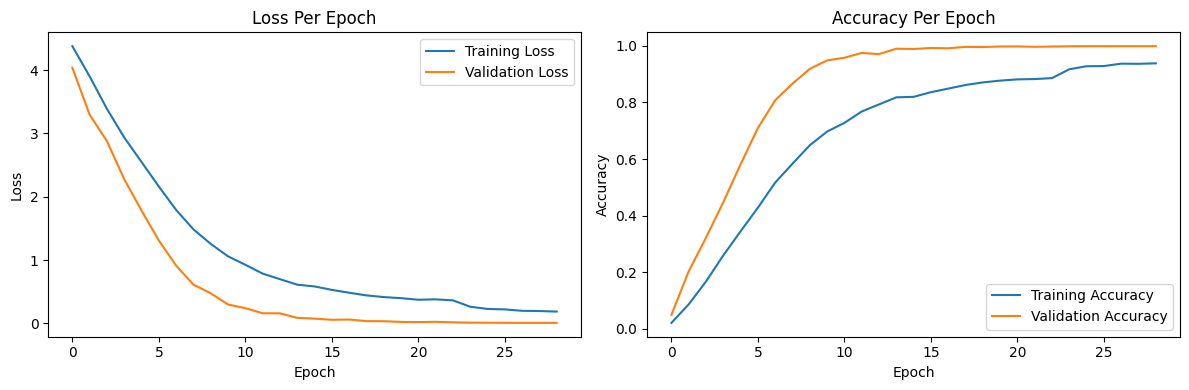

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
model.save('v2_best_model_saved.h5')  # Save in HDF5 format

In [44]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

# Dictionary kelas yang memetakan angka ke nama kelas
class_names_dict = {
    0: "amparan_tatak", 1: "asam_padeh", 2: "asem_asem daging", 3: "ayam_geprek", 
    4: "ayam_goreng_tepung", 5: "ayam_pop", 6: "ayam_rica_rica", 7: "ayam_tangkap", 
    8: "babi_guling", 9: "babi_panggang_karo", 10: "bakmi_jawa", 11: "bakpia", 
    12: "bakso", 13: "bakwan", 14: "barongko", 15: "batagor", 16: "bika_ambon", 
    17: "bolu_kojo", 18: "botok_telur_asin", 19: "bubur_ayam", 20: "burgo", 
    21: "cimol", 22: "cireng", 23: "combro", 24: "coto_makassar", 25: "daging_masak_hitam", 
    26: "dawet", 27: "dendeng_balado", 28: "es_puter", 29: "es_selendang_mayang", 
    30: "gado_gado", 31: "gudeg", 32: "gulai", 33: "jalangkote", 34: "kapurung", 
    35: "karedok", 36: "keciput", 37: "kerak_telor", 38: "kolak", 39: "kua_klepon", 
    40: "kue_cubit", 41: "kue_jojorong", 42: "kue_kamir", 43: "kue_kipo", 
    44: "kue_nagasari", 45: "kue_putu", 46: "kue_satu", 47: "kue_serabi", 
    48: "kue_wajik", 49: "kwetiau_bagan", 50: "laksamana_mengamuk", 51: "laksan", 
    52: "lalampa", 53: "lawar", 54: "luti_gendang", 55: "mendol", 56: "mi_aceh", 
    57: "nasi_goreng", 58: "nasi_uduk", 59: "opor_ayam", 60: "pallu_butung", 
    61: "pempek", 62: "pepes", 63: "perkedel", 64: "pindang_serani", 65: "pisang_ijo", 
    66: "pisang_molen", 67: "pisang_peppe", 68: "plecing_kangkung", 69: "pukis", 
    70: "rawon", 71: "rendang", 72: "rengginang", 73: "roti_buaya", 74: "roti_canai", 
    75: "roti_ganjel_rel", 76: "roti_jala", 77: "rujak_kuah_pindang", 78: "sate", 
    79: "sate_buntel", 80: "sate_padang", 81: "seblak", 82: "selat_solo", 
    83: "semur_jengkol", 84: "sop_konro", 85: "soto_ayam", 86: "soto_bandung", 
    87: "tahu_aci", 88: "tahu_gejrot", 89: "tahu_sumedang", 90: "tapai_singkong", 
    91: "tinutuan", 92: "tumpeng"
}

# Fungsi untuk preprocessing gambar
def preprocess_image(image_path, input_shape):
    image = load_img(image_path, target_size=input_shape[:2])
    image = image.convert("RGB")  # Pastikan gambar dalam format RGB
    image = img_to_array(image) / 255.0  # Normalisasi
    return np.expand_dims(image, axis=0)  # Menambah dimensi batch

# Load the model
model_path = "food_.h5"  # Ganti dengan path model .h5 Anda
model = tf.keras.models.load_model(model_path)

# Path gambar yang ingin diuji
image_path = "./babi-guling.jpeg"  # Ganti dengan path gambar uji Anda

# Preprocess gambar
input_shape = (128, 128, 3)  # Sesuaikan dengan input shape model Anda
image = preprocess_image(image_path, input_shape)

# Melakukan prediksi
predictions = model.predict(image)

# Menampilkan hasil prediksi
predicted_class = np.argmax(predictions, axis=1)
predicted_class_name = class_names_dict[predicted_class[0]]

print(f"Gambar: {image_path}")
print(f"Prediksi Kelas: {predicted_class_name} dengan probabilitas {np.max(predictions):.4f}")


1/1 [==============================] - 0s 61ms/step
Gambar: ./babi1.jpeg
Prediksi Kelas: sop_konro dengan probabilitas 0.6997
